In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#Load the dataset
data_file = 'delhi_aqi.csv'
df = pd.read_csv(data_file, sep=',')

# AQI breakpoints
#  CPCB reference values
pm25_bp = [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200),(91, 120, 201, 300), (121, 250, 301, 400), (251, 350, 401, 500)]
pm10_bp = [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200),(251, 350, 201, 300), (351, 430, 301, 400), (431, 500, 401, 500)]
no2_bp = [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200),(181, 280, 201, 300), (281, 400, 301, 400), (401, 1000, 401, 500)]
so2_bp = [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200),(381, 800, 201, 300), (801, 1600, 301, 400), (1601, 2000, 401, 500)]
co_bp = [(0, 1000, 0, 50), (1001, 2000, 51, 100), (2001, 10000, 101, 200),(10001, 17000, 201, 300), (17001, 34000, 301, 400), (34001, 50000, 401, 500)]
o3_bp = [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200),(169, 208, 201, 300), (209, 748, 301, 400), (749, 1000, 401, 500)]


#AQI Subindex calculation
def compute_subindex(val, breakpoints):
    """Approximate sub-index using simple linear interpolation"""
    for (low_bp, high_bp, low_aqi, high_aqi) in breakpoints:
        if low_bp <= val <= high_bp:
            # little linear scaling
            return ((high_aqi - low_aqi) / (high_bp - low_bp)) * (val - low_bp) + low_aqi
    return np.nan  # fallback if out of range


#Compute AQI sub-indices
df['AQI_PM25'] = df['pm2_5'].apply(lambda v: compute_subindex(v, pm25_bp))
df['AQI_PM10'] = df['pm10'].apply(lambda v: compute_subindex(v, pm10_bp))
df['AQI_NO2'] = df['no2'].apply(lambda v: compute_subindex(v, no2_bp))
df['AQI_SO2'] = df['so2'].apply(lambda v: compute_subindex(v, so2_bp))
df['AQI_CO'] = df['co'].apply(lambda v: compute_subindex(v, co_bp))
df['AQI_O3'] = df['o3'].apply(lambda v: compute_subindex(v, o3_bp))

# quick peek — helps catch weird values early
print("AQI subindices calculated (sample):")
print(df[['AQI_PM25', 'AQI_PM10', 'AQI_NO2']].head(), "\n")

# Net AQI
aqi_columns = ['AQI_PM25', 'AQI_PM10', 'AQI_NO2', 'AQI_SO2', 'AQI_CO', 'AQI_O3']
df['Net_AQI'] = df[aqi_columns].max(axis=1)  # choosing the worst one (classic method)

# CO unit correction
# Note: original data has CO in micro g/m³ — dividing by 1000 for mg/m³
df['co'] = df['co'] / 1000.0

# Clean up missing values
df = df.dropna(how='any')
print(f"Rows remaining after cleanup: {len(df)}")

#Normalization
# Skipping date and AQI since those shouldn't be scaled
cols_to_norm = [c for c in df.columns if c not in ['date', 'Net_AQI']]
scaler = MinMaxScaler()
df[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])

# Just to check if scaling worked (0–1 range)
print("Scaled value check")
print(df[cols_to_norm].describe().T[['min', 'max']])

#Save final output
output_file = "delhi_aqi_minmax_normalized.csv"
df.to_csv(output_file, index=False)
print(f"Normalized dataset saved to: {output_file}")

#Covariance Matrix
feature_columns = [c for c in df.columns if c not in ['date', 'Net_AQI']]
cov_matrix = df[feature_columns].cov()
print("Covariance Matrix:")
print(cov_matrix)


AQI subindices calculated (sample):
   AQI_PM25    AQI_PM10     AQI_NO2
0       NaN  377.104684   88.189744
1       NaN  480.214348  109.110000
2       NaN         NaN  120.080000
3       NaN         NaN  131.040000
4       NaN         NaN  137.900000 

Rows remaining after cleanup: 13330
Scaled value check
          min  max
co        0.0  1.0
no        0.0  1.0
no2       0.0  1.0
o3        0.0  1.0
so2       0.0  1.0
pm2_5     0.0  1.0
pm10      0.0  1.0
nh3       0.0  1.0
AQI_PM25  0.0  1.0
AQI_PM10  0.0  1.0
AQI_NO2   0.0  1.0
AQI_SO2   0.0  1.0
AQI_CO    0.0  1.0
AQI_O3    0.0  1.0
Normalized dataset saved to: delhi_aqi_minmax_normalized.csv
Covariance Matrix:
                co        no       no2        o3       so2     pm2_5  \
co        0.021927  0.011054  0.015318 -0.009952  0.004086  0.029683   
no        0.011054  0.009721  0.005259 -0.005326  0.002502  0.012184   
no2       0.015318  0.005259  0.019019 -0.007816  0.007773  0.020036   
o3       -0.009952 -0.005326 -0.007816

Data loaded: (13330, 16)
               date        co        no       no2        o3       so2  \
0  25-11-2020 07:00  0.220961  0.069452  0.453581  0.160723  0.454755   
1  25-11-2020 08:00  0.163319  0.055542  0.484258  0.168962  0.536796   

      pm2_5      pm10       nh3  AQI_PM25  AQI_PM10   AQI_NO2   AQI_SO2  \
0  0.889878  0.689781  0.097633  0.922462  0.586840  0.496284  0.647439   
1  0.779785  0.595376  0.049362  0.844946  0.492389  0.524564  0.701383   

     AQI_CO    AQI_O3  Net_AQI  
0  0.524685  0.233606   462.76  
1  0.390490  0.245581   425.53   

Training Decision Tree...


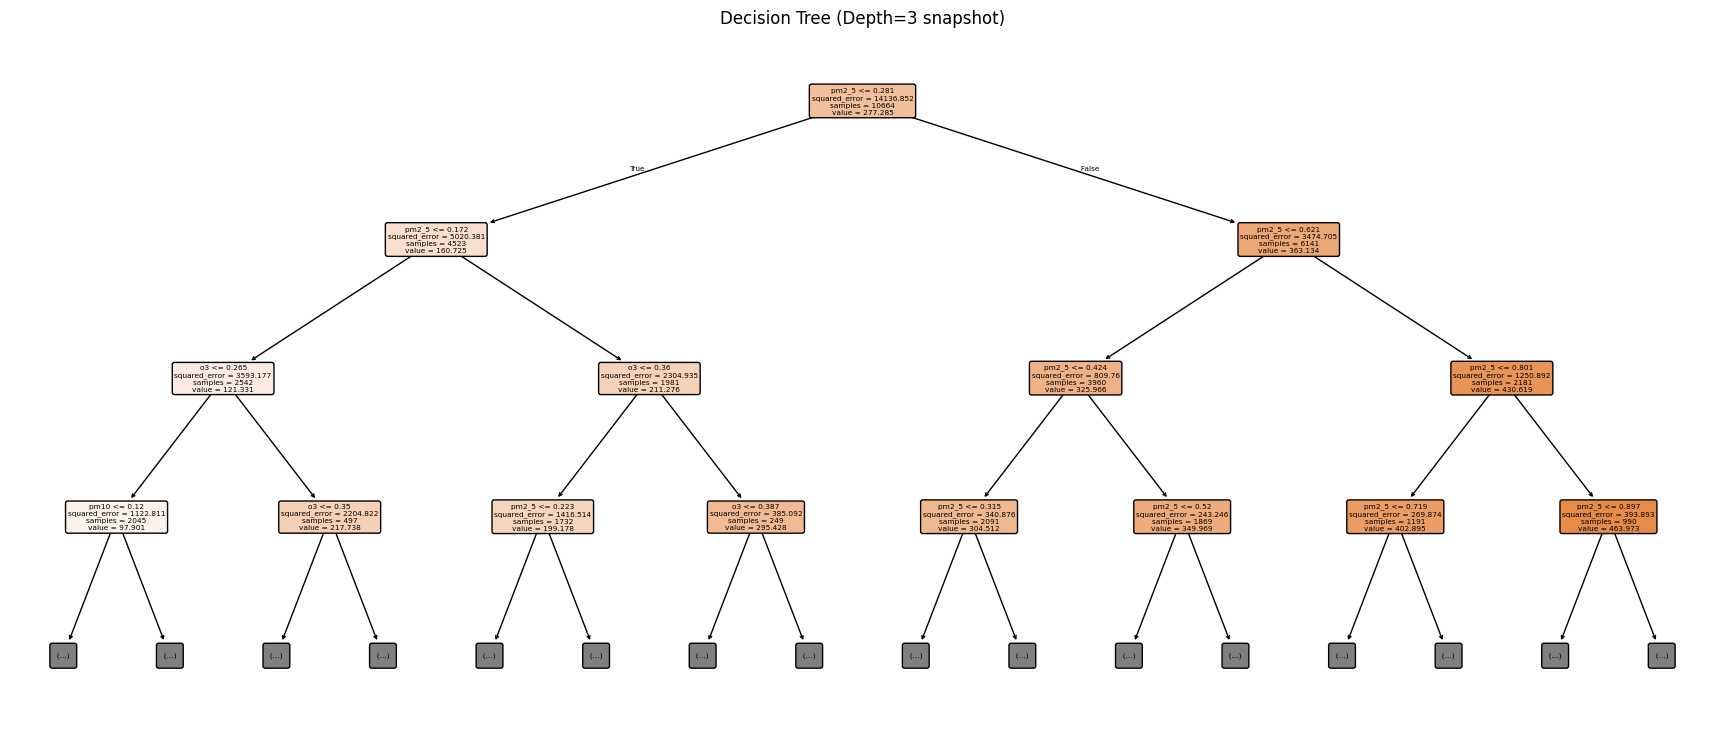

Training Random Forest (might take a bit)


/tmp/ipython-input-2872029058.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_imp, x='Importance', y='Feature', palette='viridis')


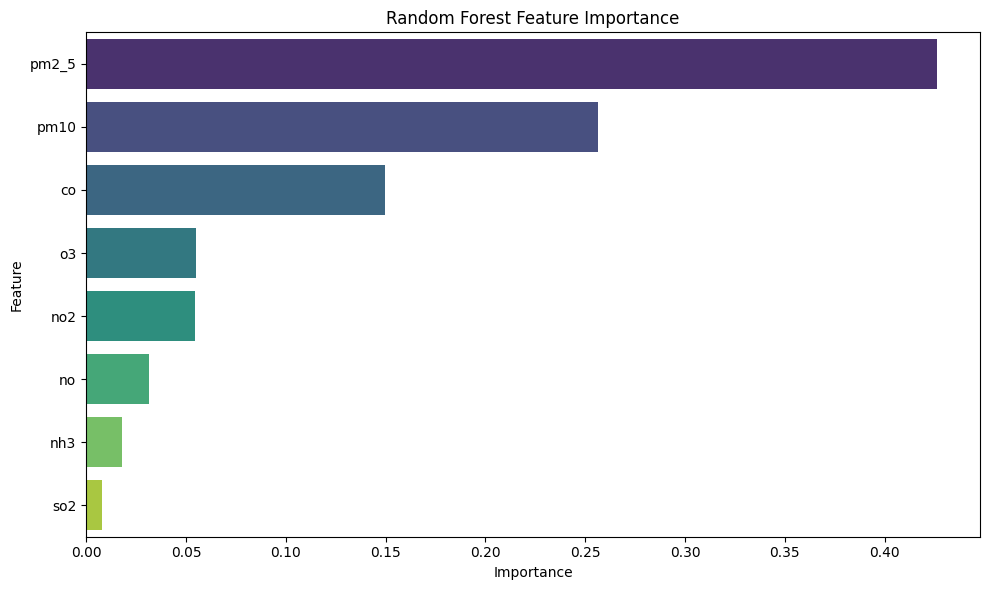

Training XGBoost model
Top features (XGBoost)
Feature  Importance
  pm2_5      0.8674
     o3      0.1001
   pm10      0.0278
    so2      0.0038
    nh3      0.0005
    no2      0.0003
     co      0.0002
     no      0.0001
Training LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2037
[LightGBM] [Info] Number of data points in the train set: 10664, number of used features: 8
[LightGBM] [Info] Start training from score 277.285091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

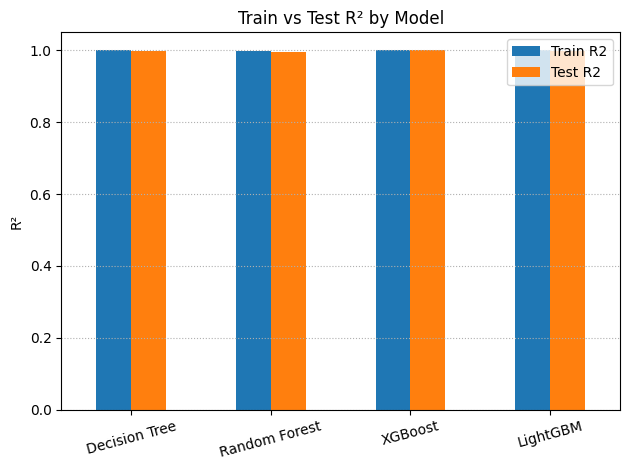

<Figure size 1000x600 with 0 Axes>

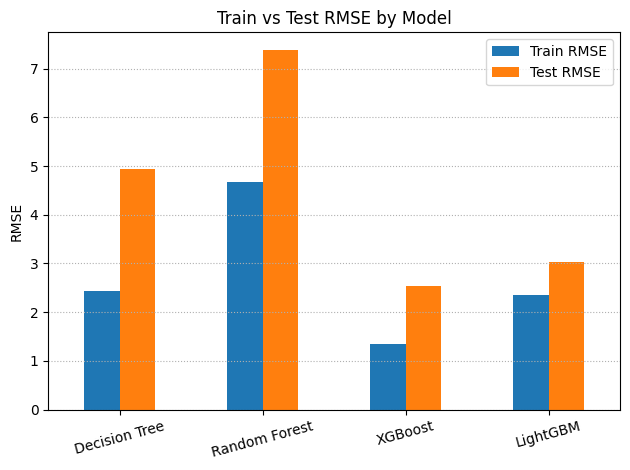

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

#Load preprocessed data
data_path = 'delhi_aqi_minmax_normalized.csv'
df = pd.read_csv(data_path)
print("Data loaded:", df.shape)
print(df.head(2), "\n")

# pick features and target (avoiding date + Net_AQI)
feature_cols = [c for c in df.columns if c not in ['date', 'Net_AQI','AQI_CO','AQI_PM25',"AQI_PM10","AQI_NO2","AQI_SO2","AQI_O3"]]
X = df[feature_cols].values
y = df['Net_AQI'].values
# train/test split — simple 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}  # will store performance summaries


# Decision Tree Regressor
print("Training Decision Tree...")
dtree = DecisionTreeRegressor(max_depth=10, random_state=42)
dtree.fit(X_train, y_train)
train_pred_dt = dtree.predict(X_train)
test_pred_dt = dtree.predict(X_test)
# evaluate and store
results['Decision Tree'] = {'Train R2': r2_score(y_train, train_pred_dt),'Test R2': r2_score(y_test, test_pred_dt),'Train RMSE': np.sqrt(mean_squared_error(y_train, train_pred_dt)),'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred_dt))
}
# quick visualization of first few branches
plt.figure(figsize=(22, 9))
plot_tree(dtree, max_depth=3, feature_names=feature_cols, filled=True, rounded=True)
plt.title('Decision Tree (Depth=3 snapshot)')
plt.show()


# ====================================================
# Random Forest Regressor
print("Training Random Forest (might take a bit)")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    max_features='sqrt',
    min_samples_split=4,
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
train_pred_rf = rf.predict(X_train)
test_pred_rf = rf.predict(X_test)
results['Random Forest'] = {
    'Train R2': r2_score(y_train, train_pred_rf),
    'Test R2': r2_score(y_test, test_pred_rf),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, train_pred_rf)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred_rf))
}

# feature importance chart (for the sake of visibility)
rf_imp = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=rf_imp, x='Importance', y='Feature', palette='viridis')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


# ====================================================
# XGBoost Regressor
print("Training XGBoost model")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
train_pred_xgb = xgb_model.predict(X_train)
test_pred_xgb = xgb_model.predict(X_test)
results['XGBoost'] = {'Train R2': r2_score(y_train, train_pred_xgb),'Test R2': r2_score(y_test, test_pred_xgb),'Train RMSE': np.sqrt(mean_squared_error(y_train, train_pred_xgb)),'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred_xgb))
}
xgb_imp = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Top features (XGBoost)")
print(xgb_imp.head(10).to_string(index=False, float_format='%.4f'))


# ====================================================
# LightGBM Regressor
print("Training LightGBM")
lgbm = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=5,
    objective='regression',
    random_state=42,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)
train_pred_lgbm = lgbm.predict(X_train)
test_pred_lgbm = lgbm.predict(X_test)
results['LightGBM'] = {'Train R2': r2_score(y_train, train_pred_lgbm),'Test R2': r2_score(y_test, test_pred_lgbm),'Train RMSE': np.sqrt(mean_squared_error(y_train, train_pred_lgbm)),'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred_lgbm))
}


# ====================================================
# Results Summary
results_df = pd.DataFrame(results).T
print(" Model Performance Summary")
print(results_df.to_string(float_format='%.4f'))
#R2 Comparison
plt.figure(figsize=(10, 6))
results_df[['Train R2', 'Test R2']].plot(kind='bar')
plt.title('Train vs Test R² by Model')
plt.ylabel('R²')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle=':')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
#RMSE Comparison
plt.figure(figsize=(10, 6))
results_df[['Train RMSE', 'Test RMSE']].plot(kind='bar')
plt.title('Train vs Test RMSE by Model')
plt.ylabel('RMSE')
plt.grid(axis='y', linestyle=':')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


no additional pruning is necessary; = models are already generalizing well. Pruning is only needed if there are clear signs of overfitting, such as a much higher train score versus test score, or unreasonably complex tree structures with noisy data